In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf 
import matplotlib as mlt
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
sys.path.append("../src/")
import torch
import torch.nn as nn
from mgpt.dataset  import AstroDataset
from mgpt.model import GenerateEmbeddings, CausalAttention, MultiHeadAttention
from mgpt.model import Mini_AstroGPT_Model
from mgpt.train import train_model

### Reading the training text file

In [2]:
with open("../data/train_data.txt", "r", encoding="utf-8") as f:
    raw_text_train = f.read()
    
with open("../data/val_data.txt", "r", encoding="utf-8") as f1:
    raw_text_val = f1.read()

In [3]:
raw_text_train[:100]

'One of the main bottleneck in assessing the accuracy of Mars orbit is the unknown value of the aster'

### Loading the dataset into the pytorch and converting to token ids

In [4]:
train_data = AstroDataset(raw_text_train, max_length=4, batch_size=3, stride=256)
my_data_train = train_data.create_dataloader(shuffle=False)

val_data = AstroDataset(raw_text_val, max_length=4, batch_size=3, stride=256)
my_data_val = val_data.create_dataloader(shuffle=False)

data_iter = iter(my_data_train)
first_batch = next(data_iter)
print("First_batch shape", np.shape(first_batch))
print("First Batch:", first_batch)

First_batch shape (2, 3, 4)
First Batch: [tensor([[ 3198,   286,   262,  1388],
        [ 2785,  5871,   286,   890],
        [ 1900,   355,  7559, 31673]]), tensor([[  286,   262,  1388, 49936],
        [ 5871,   286,   890,    12],
        [  355,  7559, 31673, 10538]])]


In [5]:
inputs, targets = first_batch      # shape: (batch, seq_len)
sample = inputs[0, :]              # tokens for the first sequence
decoded_text = train_data.data_decoder(sample.tolist())
print("Decoded text:", decoded_text)

Decoded text: One of the main


### Checking the output of the GPT model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params_dict = {
    "max_length": 6,
    "batch_size": 1,
    "vocab_size": 50257,
    "embed_dim": 64,
    "context_dim": 16,
    "num_heads": 4,
    "num_layers": 2,
    "dropout": 0.0,
}

astro_dataset = AstroDataset(raw_text_train, max_length=params_dict["max_length"], batch_size=params_dict["batch_size"])

model = Mini_AstroGPT_Model(params_dict).to(device)
model.eval()

input_ids, targets = astro_dataset[0] 
input_ids = input_ids.unsqueeze(0).to(device)  
with torch.no_grad():
    logits = model(input_ids)
    probas = torch.softmax(logits, dim=-1)
    next_token_id = torch.argmax(probas)

In [ ]:
full_token_ids = input_ids[0].tolist() + [int(next_token_id)]
decoded_text = astro_dataset.data_decoder(full_token_ids)
print("Decoded text after generation:", decoded_text)

In [8]:
print(np.shape(input_ids))

torch.Size([1, 6])


### Training

In [3]:
import tiktoken

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params_dict = {
    "max_length": 256,
    "batch_size": 32,
    "stride": 256,
    "vocab_size": 50257,
    "embed_dim": 64,
    "context_dim": 256,
    "num_heads": 4,
    "num_layers": 2,
    "dropout": 0.0,
    "num_epochs":10,
    "eval_iter":32,
    "eval_freq":100,
    "max_new_tokens":20,
    "start_context":"The star",
    "lr":0.0004,
    "weight_decay":0.01
    
}

astro_dataset_train = AstroDataset(raw_text_train, max_length=params_dict["max_length"], 
                                   batch_size=params_dict["batch_size"],
                                   stride=params_dict["stride"])
astro_dataset_val = AstroDataset(raw_text_val, max_length=params_dict["max_length"], 
                                 batch_size=params_dict["batch_size"],
                                 stride=params_dict["stride"])

my_data_train = astro_dataset_train.create_dataloader(shuffle=False)
my_data_val = astro_dataset_val.create_dataloader(shuffle=False)


model = Mini_AstroGPT_Model(params_dict).to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                            lr=params_dict["lr"], 
                            weight_decay=params_dict["weight_decay"])

# tokenizer = tiktoken.get_encoding('gpt2')

trainer = train_model(
    model=model,
    train_data_loader=my_data_train,
    val_data_loader=my_data_val,
    optimizer=optimizer,
    device=device,
    num_epochs=params_dict["num_epochs"],          # number of epochs you want
    eval_iter=params_dict["eval_iter"],         # not used in your code
    eval_freq=params_dict["eval_freq"],          # evaluate every 100 steps
    start_context=params_dict["start_context"],  # text prompt for sample generation
    max_new_tokens=params_dict["max_new_tokens"],
    num_batches=params_dict["batch_size"]        
)


In [4]:
print(len(my_data_train.dataset))
print(my_data_train.batch_size)
print(len(my_data_train))

7553
32
236


In [5]:
train_losses, val_losses, tokens_seen = trainer.train_model_basic()

Ep 1 (Step 000100): Train loss 21.175, Val loss 21.027
Ep 1 (Step 000200): Train loss 16.288, Val loss 16.334
Ep 2 (Step 000300): Train loss 13.276, Val loss 13.127
Ep 2 (Step 000400): Train loss 10.802, Val loss 10.917
Ep 3 (Step 000500): Train loss 9.562, Val loss 9.559
Ep 3 (Step 000600): Train loss 8.652, Val loss 8.722
Ep 3 (Step 000700): Train loss 8.285, Val loss 8.194
Ep 4 (Step 000800): Train loss 7.823, Val loss 7.838
Ep 4 (Step 000900): Train loss 7.526, Val loss 7.589
Ep 5 (Step 001000): Train loss 7.364, Val loss 7.414
Ep 5 (Step 001100): Train loss 7.377, Val loss 7.287
Ep 6 (Step 001200): Train loss 7.282, Val loss 7.198
Ep 6 (Step 001300): Train loss 6.987, Val loss 7.129
Ep 6 (Step 001400): Train loss 6.994, Val loss 7.077
Ep 7 (Step 001500): Train loss 6.976, Val loss 7.036
Ep 7 (Step 001600): Train loss 7.056, Val loss 7.001
Ep 8 (Step 001700): Train loss 6.836, Val loss 6.972
Ep 8 (Step 001800): Train loss 6.813, Val loss 6.945
Ep 9 (Step 001900): Train loss 6.902, 

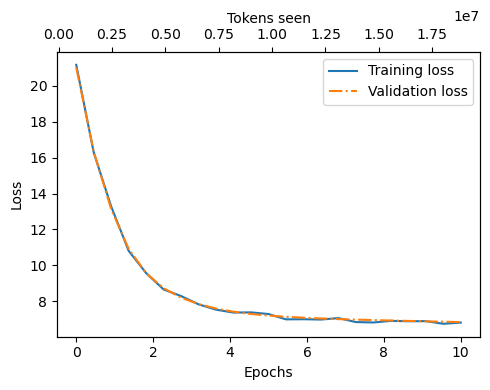

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

epochs_tensor = torch.linspace(0, params_dict["num_epochs"], len(train_losses))

fig, ax1 = plt.subplots(figsize=(5, 4))
ax1.plot(epochs_tensor, train_losses, label="Training loss")
ax1.plot(epochs_tensor, val_losses, linestyle="-.", label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2 = ax1.twiny()
ax2.plot(tokens_seen, train_losses, alpha=0)
ax2.set_xlabel("Tokens seen")
fig.tight_layout()
plt.show()


In [10]:
trainer.generate_and_print_sample()

'The star. We. We. We. We. We. We. We. We$ and the.'

### Saving the weights of the model

In [11]:
torch.save(trainer.model.state_dict(), "astroGPT_10epoch_weights.pt")